In [28]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import torch
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [31]:
!pip install transformers

In [32]:
import pandas as pd
df = pd.read_csv("/content/drive/My Drive/MinorProject/hin_train.csv")
df=df.drop(columns=['ID','Sub-task B'])
print('Number of training sentences: {:,}\n'.format(df.shape[0]))
df.sample(20)

Number of training sentences: 3,984



Text Sub-task A
408   Londe chutiye h sb. Movie dekh k bhot londo ko...        OAG
2547        Pratik tuje koi movie pasand ati ki nahi...        CAG
682                              Bade bade kele ke sath        NAG
3159  Bhai liberals ki marne ke chakkar me tumne kit...        CAG
2356  I have one question???? Can I ask u ''''''soch...        CAG
1732  Come to the point ... Yaar Kya bakchodi bana r...        CAG
3672  Aajkal chutiyea jinko Kabhi Ladki Nahi Mili, W...        OAG
3083             Bhai itna bhi insult mt kr....movie ki        NAG
402             Jootay case ka mu tode jawab sahi ki ya        CAG
1563                      Bhut bdiya acting Chandu bhai        NAG
2866  Ye review dekhne ke baad aapke review ko aaj k...        CAG
2760  @KUHU SRIVASTAVA bhai agar mai us r*ndi k naam...        OAG
2924               Mujhe bahoot achhi lagi kabir singh,        NAG
3864  Youth ko marg darshan aur Roshni dikhate hue P...        NAG
1424                     O istri friendship karogi 🤣🤣🤣🤣        NAG
410   Bhai app sensor board ka member thodi hoo,Gyan...        NAG
109     Shewtaab bhai  \nReview on movie joker 🃏 plssss        NAG
1978                 Bhai Dark season 2 ka review karna        NAG
1688                       Aap pehle se mote ho gaye ho        NAG
432                                           Maa chuda        OAG

In [33]:
df['Sub-task A'] = df['Sub-task A'].map({'CAG': 0, 'NAG':1,'OAG':2})
df.head()

Text  Sub-task A
0  Bollywood film dekhne ke samay logic ghar mein...           1
1                                   Chutiya movie...           1
2  Us jaat bnde ka khene ka matlab tha mar daluga...           2
3  @Feminism Is CANCER *un feminist yeh sahi hai ...           2
4       Amrit Anand अब तो जुड़े ही है उनको बोलो जुड़ने           1

In [0]:
df=df.rename(columns={"Sub-task A":"label"})

In [0]:
sentences = df.Text.values
labels = df.label.values

In [36]:
sentences

array(['Bollywood film dekhne ke samay logic ghar mein chorke ana parta hain.  \nPlease logic mat ghusao',
       'Chutiya movie...',
       'Us jaat bnde ka khene ka matlab tha mar daluga use but gand fat gyi camera\ndekh ke chutiya sala shkl se hi frustrated lag rha hai for sure ye bnda andar\nhi andar gay hoga but iski andar ita dum nahi hoga ki confess kre tabhi sala\nage bhi apne bacho mai khaouf fila rha hai ..chutiya kahinka',
       ..., 'konsa place hai bhai ...nam bolo',
       'Kuch zada hi likh diya 🙄',
       'scary tube par kya woh karna sahi tha? Pucha kya usne kiss karne pe dikkat toh\nnahi h? Agar tumhare logic se chaley toh pehle kand kardo...fir dekha\njayega....’CONSENT’ samjho'],
      dtype=object)

In [37]:
labels

array([1, 1, 2, ..., 1, 1, 1])

In [0]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [39]:
input_ids = []
for sent in sentences:
    encoded_sent = tokenizer.encode(
                        sent, 
                        add_special_tokens = True,
                   )
    input_ids.append(encoded_sent)

Token indices sequence length is longer than the specified maximum sequence length for this model (1838 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (734 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (767 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1618 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (588 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

In [40]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  1840


In [0]:
from keras.preprocessing.sequence import pad_sequences
MAX_LEN = 100
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

In [0]:
attention_masks = []
for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)

In [0]:
from sklearn.model_selection import train_test_split
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=42, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=42, test_size=0.1)

In [0]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [46]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 3, 
    output_attentions = False,
    output_hidden_states = False,
)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [47]:
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [0]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )


In [0]:
from transformers import get_linear_schedule_with_warmup
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [0]:
import numpy as np
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [52]:
import random
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
loss_values = []
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time()
    total_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_loss / len(train_dataloader)            
    loss_values.append(avg_train_loss)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
    print("")
    print("Running Validation...")
    t0 = time.time()
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    113.    Elapsed: 0:00:42.
  Batch    80  of    113.    Elapsed: 0:01:24.

  Average training loss: 0.93
  Training epcoh took: 0:01:57

Running Validation...
  Accuracy: 0.58
  Validation took: 0:00:05

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    113.    Elapsed: 0:00:42.
  Batch    80  of    113.    Elapsed: 0:01:23.

  Average training loss: 0.76
  Training epcoh took: 0:01:57

Running Validation...
  Accuracy: 0.63
  Validation took: 0:00:05

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    113.    Elapsed: 0:00:42.
  Batch    80  of    113.    Elapsed: 0:01:23.

  Average training loss: 0.64
  Training epcoh took: 0:01:57

Running Validation...
  Accuracy: 0.67
  Validation took: 0:00:05

======== Epoch 4 / 4 ========
Training...
  Batch    40  of    113.    Elapsed: 0:00:42.
  Batch    80  of    113.    Elapsed: 0:01:23.

  Average training loss: 0.56
  Training epcoh took: 0:01:57

Ru

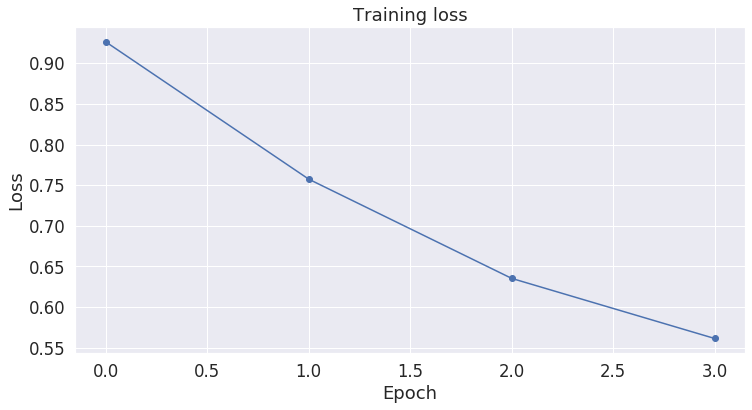

In [53]:
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(loss_values, 'b-o')
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [56]:
df1 = pd.read_csv("/content/drive/My Drive/MinorProject/hin_dev.csv")
df1=df1.drop(columns=['ID','Sub-task B'])
print('Number of test sentences: {:,}\n'.format(df1.shape[0]))
df1['Sub-task A'] = df1['Sub-task A'].map({'CAG': 0, 'NAG':1,'OAG':2})
df1

Number of test sentences: 997



Text  Sub-task A
0    bkl interviewers kuch jaada hi open minded bnt...           2
1    Bhaiya shaadi mein zaroor aana movie ka plot j...           1
2    Section 375 hai kya??? .... Ye to batate kam s...           1
3    कबीर सिंह hit Hui इससे पता चलता है आजकल के लोग...           2
4               Maine itni kam dislike kbhi nhii dekhi           1
..                                                 ...         ...
992              Are bhai konsi duniya mai rehate ho😂😂           1
993                                       Sahi to bola           1
994                            Or tum Kay Kar raya ho?           1
995  Ye bhaat sahi hain par zyada dhin thine ga nah...           1
996               Islye maine Kabaad singh nai dekha..           1

[997 rows x 2 columns]

In [0]:
df1=df1.rename(columns={"Sub-task A":"label"})
sentences = df1.Text.values
labels = df1.label.values


In [58]:
input_ids = []
for sent in sentences:
    encoded_sent = tokenizer.encode(
                        sent,                     
                        add_special_tokens = True, 
                                           )
    
    input_ids.append(encoded_sent)
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")
attention_masks = []
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
batch_size = 32  
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Token indices sequence length is longer than the specified maximum sequence length for this model (577 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (651 > 512). Running this sequence through the model will result in indexing errors


In [59]:

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))
model.eval()
predictions , true_labels = [], []
for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch  
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  predictions.append(logits) 
  true_labels.append(label_ids)


Predicting labels for 997 test sentences...


In [60]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 4065 of 3984 (102.03%)


In [61]:
from sklearn.metrics import classification_report
clf_set = []
for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  clf = classification_report(true_labels[i], pred_labels_i)                
  clf_set.append(clf)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
clf = classification_report(flat_true_labels, flat_predictions)
print(clf)

              precision    recall  f1-score   support

           0       0.45      0.43      0.44       211
           1       0.79      0.84      0.81       578
           2       0.61      0.54      0.57       208

    accuracy                           0.69       997
   macro avg       0.62      0.60      0.61       997
weighted avg       0.68      0.69      0.68       997

